# Load packages

In [1]:
# pip install gymnasium

In [3]:
#pip install 'stable-baselines3[extra]'

zsh:1: no matches found: stable-baselines3[extra]


In [3]:
#!pip install gym==0.25.2

In [1]:
# the Gym environment class
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# used for clearing the display in jupyter notebooks
from IPython.display import clear_output
import os
import random
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
from itertools import count

from stable_baselines3 import PPO, DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, CallbackList

import tensorflow as tf

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Helpers

In [3]:
a = np.array([0,0,2,2])
aa = np.array([4,0,0,0])
a_cpt = 4

b = np.array([0,2,2,2])
bb = np.array([4,2,0,0])
b_cpt = 4

c = np.array([2,0,2,0])
cc = np.array([4,0,0,0])
c_cpt = 4

d = np.array([0,2,0,0])
dd = np.array([2,0,0,0])
d_cpt = 0

e = np.array([2,2,2,2])
ee = np.array([4,4,0,0])
e_cpt = 8

In [4]:
def compress(x):
  y = np.array([0] * 4)

  idx = 0

  for j in range(4):
    if x[j] != 0:
      y[idx] = x[j]
      idx += 1

  return y

In [5]:
def merge(x):
  y = x

  merge_cpt = 0

  for j in range(3):
    if x[j] == x[j+1]:
      y[j] = x[j] + x[j+1]
      x[j+1] = 0
      merge_cpt += y[j]
    else:
      y[j] = x[j]

  return y, merge_cpt

In [6]:
def swipeLeft(x):
  y = compress(x)
  y, merge_cpt = merge(y)
  y = compress(y)
  return y, merge_cpt

In [7]:
sa, sa_cpt = swipeLeft(a)
sb, sb_cpt = swipeLeft(b)
sc, sc_cpt = swipeLeft(c)
sd, sd_cpt = swipeLeft(d)
se, se_cpt = swipeLeft(e)
print(aa == sa, a_cpt == sa_cpt)
print(bb == sb, b_cpt == sb_cpt)
print(cc == sc, c_cpt == sc_cpt)
print(dd == sd, d_cpt == sd_cpt)
print(ee == se, e_cpt == se_cpt)

[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True


In [8]:
m = np.array([a,b,c,d])
mm_left = np.array([aa, bb, cc, dd])
m_left_cpt = 12

mm_right = np.array([[0,0,0,4],[0,0,2,4],[0,0,0,4],[0,0,0,2]])
m_right_cpt = 12

mm_up = np.array([[2,4,4,4],[0,0,2,0],[0,0,0,0],[0,0,0,0]])
m_up_cpt = 12

mm_down = np.array([[0,0,0,0],[0,0,0,0],[0,0,2,0],[2,4,4,4]])
m_down_cpt = 12

print(m)
print(mm_left)
print(mm_right)
print(mm_up)
print(mm_down)

[[0 0 2 2]
 [0 2 2 2]
 [2 0 2 0]
 [0 2 0 0]]
[[4 0 0 0]
 [4 2 0 0]
 [4 0 0 0]
 [2 0 0 0]]
[[0 0 0 4]
 [0 0 2 4]
 [0 0 0 4]
 [0 0 0 2]]
[[2 4 4 4]
 [0 0 2 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [2 4 4 4]]


In [9]:
def swipe(mat, dir):
  t_mat = mat.copy()
  merge_cpt = 0
  match dir:
    case 'right':
      t_mat = t_mat[:, ::-1]
    case 'up':
      t_mat = np.transpose(t_mat)
    case 'down':
      t_mat = np.transpose(t_mat)[:, ::-1]

  for i in range(4):
    t_mat[i], merge_cpt_loc = swipeLeft(t_mat[i])
    merge_cpt += merge_cpt_loc

  match dir:
    case 'right':
      t_mat = t_mat[:, ::-1]
    case 'up':
      t_mat = np.transpose(t_mat)
    case 'down':
      t_mat = np.transpose(t_mat[:, ::-1])

  return t_mat, merge_cpt

In [10]:
print(swipe(m,'left')[0] == mm_left, swipe(m,'left')[1] == m_left_cpt)
print(swipe(m,'right')[0] == mm_right, swipe(m,'right')[1] == m_right_cpt)
print(swipe(m,'up')[0] == mm_up, swipe(m,'up')[1] == m_up_cpt)
print(swipe(m,'down')[0] == mm_down, swipe(m,'down')[1] == m_down_cpt)

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True


In [11]:
test = np.array([0.,  0.,  8., 64., 0.,  4., 32.,  4., 0.,  0.,  0.,  8., 2.,  0.,  0., 4.]).reshape((4,4))
result_down = np.array([0., 0., 0., 64., 0., 0., 0., 4., 0., 0., 8., 8., 2., 4., 32., 4.]).reshape((4,4))
print(swipe(test,'down')[0]==result_down)

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


# Class gym2048 definition

In [12]:
class gym2048(gym.Env):
  def __init__(self):
    self.n_grid = 4*4
    # custom class variable used to display the reward earned
    self.cumulative_reward = 0

    # observation space (valid ranges for observations in the state)
    self.observation_space = spaces.Box(shape=(16, 4, 4), low=0, high=1, dtype=np.float32)

    # valid actions:
    #   0 = left
    #   1 = right
    #   2 = up
    #   3 = down
    # spaces.Discrete(4) is a shortcut for defining the actions 0-3
    self.action_space = spaces.Discrete(4)
    self.act_dict = {0: 'left', 1:'right', 2:'up', 3:'down'}

  def _get_obs(self):
    return self.state

  def encode(self, mat):
    # Input: 4x4 matrice
    # Output: 16x4x4 tensor
    # see https://www.jstage.jst.go.jp/article/ipsjjip/29/0/29_336/_pdf/-char/en
    tensor = np.zeros((16,4,4), dtype=np.float32)
    for i in range(4):
      for j in range(4):
        if mat[i,j] > 0:
          k = int(np.log2(mat[i,j]))
          tensor[k,i,j] = 1
    return tensor

  def decode(self, tensor):
    # Input: 16x4x4 tensor
    # Output: 4x4 matrice
    # see https://www.jstage.jst.go.jp/article/ipsjjip/29/0/29_336/_pdf/-char/en
    mat = np.zeros((4,4), dtype=np.float32)
    for k in range(16):
      for i in range(4):
        for j in range(4):
          if tensor[k,i,j] == 1:
            mat[i,j] += 2**k
    return mat

  def reset(self, seed=None):
    super().reset(seed=seed)
    random.seed(seed)

    # set the initial state to a flattened 4x4 grid with two randomly Twos
    vec = np.zeros(self.n_grid, dtype=np.float32)
    index_1 = random.randrange(0, self.n_grid)
    index_2 = random.randrange(0, self.n_grid)
    while index_2 == index_1:
      index_2 = random.randrange(0, self.n_grid)
    vec[index_1] = 2
    vec[index_2] = 2

    self.state = np.array(self.encode(vec.reshape((4,4))), dtype=np.float32)

    return self.state, {}

  def step(self, action):
    reward = 0.0

    mat = self.decode(self.state)

    #zero_count = np.sum(mat == 0)
    #grid_value = np.sum(mat)
    #max_tile = np.max(mat)

    act = self.act_dict[action]
    new_mat, merge_cpt = swipe(mat, act)

    #new_zero_count = np.sum(new_mat == 0)
    #new_grid_value = np.sum(new_mat)
    new_max_tile = np.max(new_mat)
    zero_idx = np.where(new_mat == 0)
    #reach_2048 = np.where(new_mat == 2048)[0].size

    if len(zero_idx[0]) == 0:
      #terminated = (mat == swipe(mat,0)).all() and (mat == swipe(mat,1)).all() and (mat == swipe(mat,2)).all() and (mat == swipe(mat,3)).all()
      terminated = True
      reward += -100
    elif new_max_tile == 2048:
      terminated = True
      reward += 1000
    else:
      terminated = False

      #if new_zero_count <= zero_count: #reward for a match, penalty otherwise
      #  reward += float(2*(new_grid_value - grid_value))
      #else:
      #  reward += -1

      #if new_max_tile > max_tile: #reward for increasing max tile value
      #  reward += new_max_tile

      if merge_cpt > 0:
        reward += merge_cpt
      else:
        reward += -1

      rand_idx = random.randrange(0,len(zero_idx[0]))
      new_mat[zero_idx[0][rand_idx], zero_idx[1][rand_idx]] = 2

    self.state = observation = np.array(self.encode(new_mat), dtype=np.float32)

    return self.state, reward, terminated, False, {}

  def allowed_actions(self):
    a_size = int(np.sqrt(self.n_grid))
    mat = self.state.reshape((a_size, a_size))
    mat_0 = swipe(mat, 'left')
    mat_1 = swipe(mat, 'right')
    mat_2 = swipe(mat, 'up')
    mat_3 = swipe(mat, 'down')

    return [(mat != mat_0).any(), (mat != mat_1).any(), (mat != mat_2).any(), (mat != mat_3).any()]

In [13]:
env = gym2048()
env = Monitor(env, filename="./logs/")

In [14]:
check_env(env, warn=True)

/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:54: UserWarning: It seems that your observation  is an image but its `dtype` is (float32) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:62: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/preprocessing.py:23: UserWarning: Treating image space as channels-last, while second dimension was smallest of the three.
  warnings.warn("Treating image space as channels-last, while second dimension was smallest of the three.")
/opt/homebrew/lib/python3.10/

In [16]:
terminated = False

env.reset()

cpt = 0
cum_reward = 0

while terminated == False:
  cpt += 1
  action = random.randrange(0,4)
  observation, reward, terminated, _, _ = env.step(action)
  cum_reward += reward

print(env.unwrapped.decode(observation))
print(cum_reward)
print(cpt)

[[ 4. 16.  4.  8.]
 [ 8.  4.  8. 16.]
 [ 2.  2. 16.  4.]
 [ 4.  8.  4.  2.]]
114.0
54


In [17]:
def evaluate(env, model=None, n_games=1000):
  max_tiles = np.array([])
  n_steps = np.array([])

  for k in tqdm(range(n_games)):
    terminated = False
    cpt = 0
    state, _ = env.reset()
    observation = torch.tensor(state, dtype=torch.int16).unsqueeze(0)

    while terminated == False:
      cpt += 1

      if model:
        action, _ = model.predict(observation=observation)
        observation, reward, terminated, _, _ = env.step(action.item())
      else:
        action = random.randrange(0,4)
        observation, reward, terminated, _, _ = env.step(action)

    max_tiles = np.append(max_tiles, np.max(env.decode(observation)))
    n_steps = np.append(n_steps, cpt)

  return max_tiles, n_steps

In [23]:
if False:
  random_max_tiles, random_n_steps = evaluate(env, n_games=1000)

  data = {
      'max_tiles': random_max_tiles,
      'n_steps': random_n_steps
      }

  with open('./2048_random.pkl', 'wb') as file:
      pickle.dump(data, file)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.82it/s]


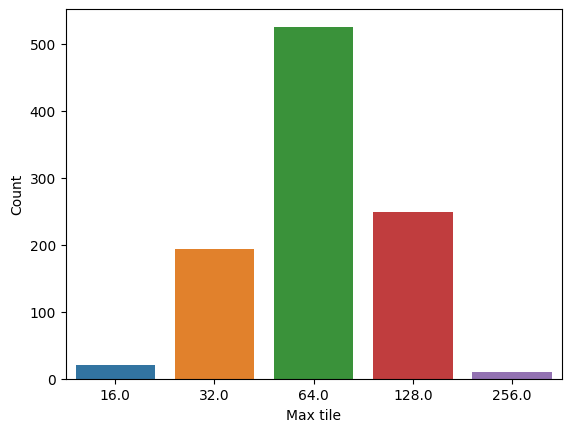

In [18]:
with open('./2048_random.pkl', 'rb') as file:
    data = pickle.load(file)

df_random = pd.DataFrame({'max_tiles':data['max_tiles']})
df_random['model'] = "Random"

sns.countplot(df_random, x="max_tiles")
plt.xlabel('Max tile')
plt.ylabel('Count')
plt.show()

# Plot callback & Monitor wrapper

In [19]:
class PlotCallback(BaseCallback):
    def __init__(self, update_freq=1000, window=50, verbose=0):
        super(PlotCallback, self).__init__(verbose)
        self.check_freq = update_freq
        self.episode_rewards = []
        self.episode_reward = 0
        self.fig, self.ax = plt.subplots()

    def _on_step(self) -> bool:
        # Increment the current episode reward with the reward of this step
        self.episode_reward += self.locals["rewards"][0]

        # Check if the episode is done
        if self.locals["dones"][0]:
            # Append the total reward for the completed episode
            self.episode_rewards.append(self.episode_reward)
            # Reset the episode reward
            self.episode_reward = 0

        # Every check_freq steps, update the plot
        if len(self.episode_rewards) % self.check_freq == 0 and len(self.episode_rewards) > 0:
            clear_output(wait=True)  # Clear the previous plot

            # Create a new plot with episode rewards
            plt.figure(figsize=(10, 5))
            plt.plot(self.episode_rewards, label="Episode Reward")
            plt.xlabel("Episodes")
            plt.ylabel("Reward")
            plt.title("Episode Rewards over Time")

            if len(self.episode_rewards) >= 100:
              df = pd.DataFrame({'episode_rewards':self.episode_rewards})
              df['rolling_avg'] = df['episode_rewards'].rolling(window=100).mean()
              plt.plot(df['rolling_avg'])

            plt.legend()
            plt.grid()
            plt.show()

        return True

    def _on_rollout_end(self):
        pass  # This method is not needed anymore, as rewards are now added in _on_step

# CNN22

In [20]:
class CNN22(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super(CNN22, self).__init__(observation_space, features_dim)

        # Extract observation dimensions
        n_input_channels = observation_space.shape[0]

        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 256, kernel_size=2, stride=1),  # 1st conv layer
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=2, stride=1),  # 2nd conv layer
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the output size of the CNN
        with torch.no_grad():
            # We assume the input is a square image (check this based on your environment)
            sample_input = torch.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample_input).shape[1]

        # Fully connected layers after CNN
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Forward pass through CNN and FC layers
        return self.fc(self.cnn(observations))

# Use the custom feature extractor with PPO
policy_kwargs = dict(
    features_extractor_class=CNN22,
    features_extractor_kwargs=dict(features_dim=256)  # This matches the 256 unit dense layer in the architecture
)

# PPO / stable baseline

In [63]:
model = PPO("CnnPolicy", env, verbose=1, policy_kwargs=policy_kwargs, tensorboard_log="./drive/MyDrive/Colab Notebooks/ppo_cnn_tensorboard/")
#model = PPO.load("./drive/MyDrive/Colab Notebooks/PPO_CNN_2024_10_25/rl_model_750000_steps.zip", env=env)
plot_callback = PlotCallback(update_freq=50)
checkpoint_callback = CheckpointCallback(
    save_freq=150000,
    save_path="./drive/MyDrive/Colab Notebooks/PPO_CNN_2024_10_25/",
    save_replay_buffer=True
    )
callback = CallbackList([checkpoint_callback, plot_callback])
model.learn(total_timesteps=int(2e6), progress_bar=False, callback=callback)

KeyboardInterrupt: 

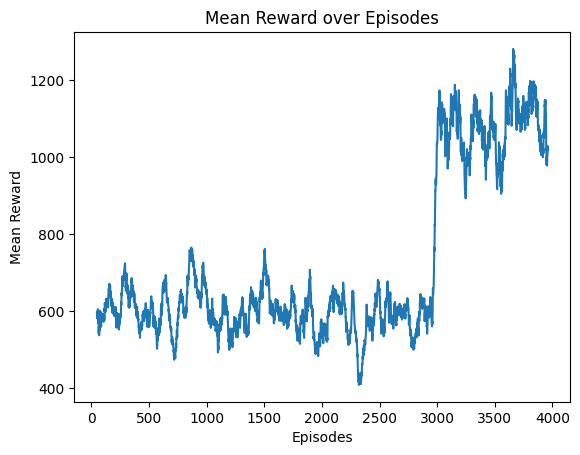

In [64]:
# Load the log file (which is a CSV)
log_data = pd.read_csv('./drive/MyDrive/Colab Notebooks/monitor.csv', skiprows=1)

# Calculate the episode mean reward
mean_reward = log_data['r'].rolling(window=50).mean()  # Smooth the rewards

# Plot the mean reward
plt.plot(mean_reward)
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.title('Mean Reward over Episodes')
plt.show()

In [47]:
model = PPO.load("./drive/MyDrive/Colab Notebooks/PPO_CNN_2024_10_25/rl_model_900000_steps.zip", env=env)

Wrapping the env in a DummyVecEnv.


In [48]:
terminated = False
print_intermediate = False

state, info = env.reset()
state = torch.tensor(state, dtype=torch.int16).unsqueeze(0)

cpt = 0
cum_reward = 0

while terminated == False and cpt < 600:
  cpt += 1
  action, _ = model.predict(observation=state)
  state, reward, terminated, _, _ = env.step(action.item())
  cum_reward += reward
  #print(env.act_dict[action.item()])
  #print(reward)
  #print(env.decode(state))

print(env.decode(state))
print(cum_reward)
print(cpt)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[  2   4  32 128]
 [  2   4  16  32]
 [  2  16   4  16]
 [  2   8   2   4]]
1057.0
136


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


In [62]:
model_max_tiles, model_n_steps = evaluate(env, model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

with open('./drive/MyDrive/Colab Notebooks/2048_ppo.pkl', 'wb') as file:
    pickle.dump(data, file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


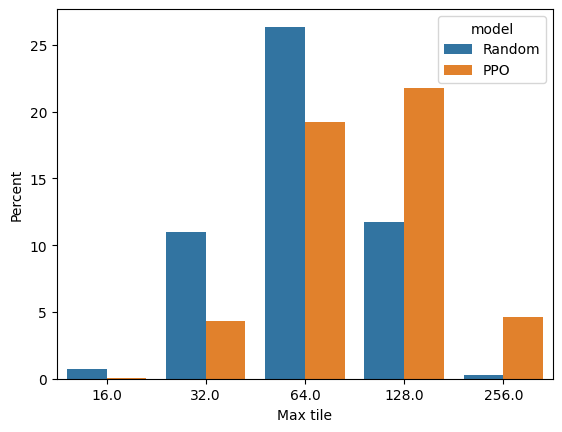

In [63]:
with open('./drive/MyDrive/Colab Notebooks/2048_ppo.pkl', 'rb') as file:
    data = pickle.load(file)

df_model = pd.DataFrame({'max_tiles':data['max_tiles']})
df_model['model'] = "PPO"

df = pd.concat([df_random, df_model], ignore_index=True)

sns.countplot(df, x="max_tiles", hue="model", stat="percent")
plt.xlabel('Max tile')
plt.ylabel('Percent')
plt.show()

# DQN stable baselines 3

In [43]:
#model = DQN(
#    "CnnPolicy",
#    env,
#    verbose=1,
#    policy_kwargs=policy_kwargs,
#    batch_size=512,
#    tensorboard_log="./DQN_CNN_2024_10_27/dqn_cnn_tensorboard/",
#    device='mps',
#    buffer_size=50000,
#    learning_rate=0.001
#    )

model = DQN.load(
    "./DQN_CNN_2024_10_26/rl_model_900000_steps.zip",
    env=env,
    learning_rate=0.001,
    batch_size=512,
    buffer_size=50000,
    device='mps',
    load_replay_buffer=True,
    tensorboard_log="./DQN_CNN_2024_10_27/dqn_cnn_tensorboard/"
)

print("Learning rate: %0.4f" % model.learning_rate)

plot_callback = PlotCallback(update_freq=50)
checkpoint_callback = CheckpointCallback(
    save_freq=150000,
    save_path="./DQN_CNN_2024_10_27/",
    save_replay_buffer=True
    )
callback = CallbackList([checkpoint_callback, plot_callback])

model.learn(total_timesteps=int(2e6), reset_num_timesteps=False, progress_bar=False, callback=callback)

KeyboardInterrupt: 

In [45]:
model = DQN.load("./DQN_CNN_2024_10_27/rl_model_2250000_steps.zip", env=env)

Wrapping the env in a DummyVecEnv.


In [49]:
terminated = False
print_intermediate = False

state, info = env.reset()
state = torch.tensor(state, dtype=torch.int16).unsqueeze(0)

cpt = 0
cum_reward = 0

while terminated == False and cpt < 600:
  cpt += 1
  action, _ = model.predict(observation=state)
  state, reward, terminated, _, _ = env.step(action.item())
  cum_reward += reward
  #print(env.act_dict[action.item()])
  #print(reward)
  #print(env.decode(state))

print(env.decode(state))
print(cum_reward)
print(cpt)

[[  2.   4.  16.  32.]
 [  2.  16.  32. 256.]
 [  4.   8.  16.  64.]
 [  4.   2.   4.  16.]]
2421.0
238


In [50]:
model_max_tiles, model_n_steps = evaluate(env, model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

with open('./2048_dqn_225k.pkl', 'wb') as file:
    pickle.dump(data, file)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.49it/s]


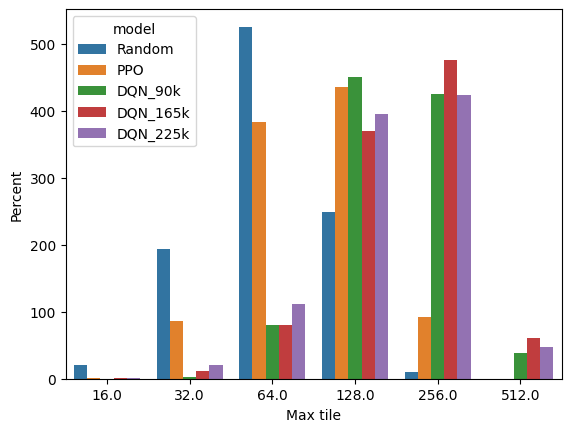

In [52]:
with open('./2048_ppo.pkl', 'rb') as file:
    data_ppo = pickle.load(file)

with open('./2048_dqn_90k.pkl', 'rb') as file:
    data_dqn_90k = pickle.load(file)
    
with open('./2048_dqn_165k.pkl', 'rb') as file:
    data_dqn_165k = pickle.load(file)  
    
with open('./2048_dqn_225k.pkl', 'rb') as file:
    data_dqn_225k = pickle.load(file) 

df_model_ppo = pd.DataFrame({'max_tiles':data_ppo['max_tiles']})
df_model_ppo['model'] = "PPO"

df_model_dqn_90k = pd.DataFrame({'max_tiles':data_dqn_90k['max_tiles']})
df_model_dqn_90k['model'] = "DQN_90k"

df_model_dqn_165k = pd.DataFrame({'max_tiles':data_dqn_165k['max_tiles']})
df_model_dqn_165k['model'] = "DQN_165k"

df_model_dqn_225k = pd.DataFrame({'max_tiles':data_dqn_225k['max_tiles']})
df_model_dqn_225k['model'] = "DQN_225k"

df = pd.concat([df_random, df_model_ppo, df_model_dqn_90k, df_model_dqn_165k, df_model_dqn_225k], ignore_index=True)

sns.countplot(df, x="max_tiles", hue="model")
plt.xlabel('Max tile')
plt.ylabel('Percent')
plt.show()